## Setup and Raw Data Ingestion

In [1]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

# Constants defined in your project methodology
OBS_LEN = 8   # 3.2 seconds of history [cite: 110]
PRED_LEN = 12 # 4.8 seconds of future prediction [cite: 114]

def load_eth_data(file_path):
    # ETH/UCY format: frame_id, ped_id, x, y [cite: 53]
    column_names = ['frame_id', 'ped_id', 'x', 'y']
    df = pd.read_csv(file_path, sep='\t', header=None, names=column_names)
    
    trajectories = []
    for ped_id, group in df.groupby('ped_id'):
        path = group[['x', 'y']].values # Bird's eye view coordinates [cite: 6, 97]
        if len(path) >= (OBS_LEN + PRED_LEN):
            trajectories.append(path)
    return trajectories

class PedestrianDataset(Dataset):
    def __init__(self, trajectories):
        self.samples = []
        for path in trajectories:
            # The "Sliding Window" to maximize training samples
            for i in range(len(path) - OBS_LEN - PRED_LEN + 1):
                obs = path[i : i + OBS_LEN]
                target = path[i + OBS_LEN : i + OBS_LEN + PRED_LEN]
                self.samples.append((obs, target))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        obs, target = self.samples[idx]
        return torch.tensor(obs, dtype=torch.float32), torch.tensor(target, dtype=torch.float32)

## The Dataset and Sliding Window

In [3]:
import os

sample_file = '../raw/eth/test/biwi_eth.txt' 

if os.path.exists(sample_file):
    raw_trajs = load_eth_data(sample_file)
    dataset = PedestrianDataset(raw_trajs)
    print(f"Total sequences generated: {len(dataset)}")
    
    # Check shape of first sample
    obs, target = dataset[0]
    print(f"Observation shape: {obs.shape}") # Should be (8, 2)
    print(f"Target shape: {target.shape}")       # Should be (12, 2)

Total sequences generated: 364
Observation shape: torch.Size([8, 2])
Target shape: torch.Size([12, 2])


## Visualization Check

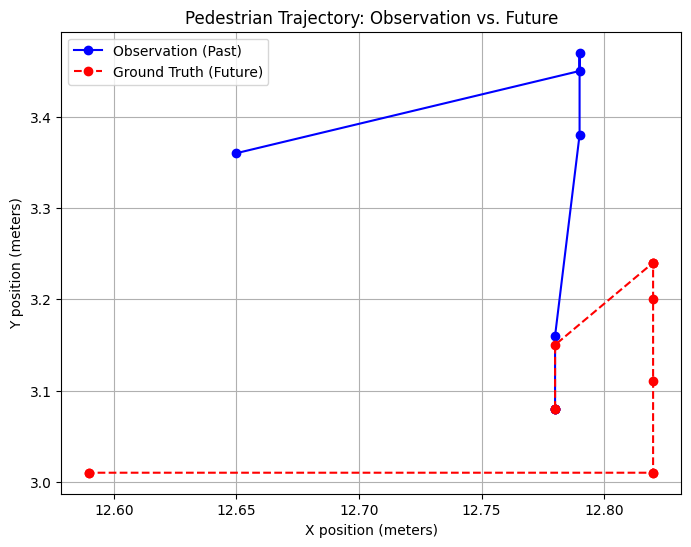

In [4]:
import matplotlib.pyplot as plt

# Grab one sample from your dataset
obs, target = dataset[50] # Looking at the 51st sequence

plt.figure(figsize=(8, 6))
# Plot the 8 steps the model "sees"
plt.plot(obs[:, 0], obs[:, 1], 'bo-', label='Observation (Past)')
# Plot the 12 steps the model is trying to "predict"
plt.plot(target[:, 0], target[:, 1], 'ro--', label='Ground Truth (Future)')

plt.title("Pedestrian Trajectory: Observation vs. Future")
plt.xlabel("X position (meters)")
plt.ylabel("Y position (meters)")
plt.legend()
plt.grid(True)
plt.show()

## Save to Repo

In [5]:
# The path to your existing processed folder 
processed_path = '../processed/eth_test_sequences.pt'

# Save only the list of (obs, target) tuples
torch.save(dataset.samples, processed_path)

print(f"✅ Data pipeline complete. {len(dataset)} sequences saved to {processed_path}")

✅ Data pipeline complete. 364 sequences saved to ../processed/eth_test_sequences.pt
